In [40]:
# 데이터 준비
df = pd.read_csv('spam.csv', encoding='latin1')
df.tail(2)

v1                                                 v2 Unnamed: 2  \
5570  ham  The guy did some bitching but I acted like i'd...        NaN   
5571  ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
5570        NaN        NaN  
5571        NaN        NaN

In [41]:
df = df[['v1', 'v2']]
df.rename({'v1': 'target', 'v2': 'text'}, axis='columns', inplace=True)
df

target                                               text
0       ham  Go until jurong point, crazy.. Available only ...
1       ham                      Ok lar... Joking wif u oni...
2      spam  Free entry in 2 a wkly comp to win FA Cup fina...
3       ham  U dun say so early hor... U c already then say...
4       ham  Nah I don't think he goes to usf, he lives aro...
...     ...                                                ...
5567   spam  This is the 2nd time we have tried 2 contact u...
5568    ham              Will Ì_ b going to esplanade fr home?
5569    ham  Pity, * was in mood for that. So...any other s...
5570    ham  The guy did some bitching but I acted like i'd...
5571    ham                         Rofl. Its true to its name

[5572 rows x 2 columns]

In [42]:
X = df[['text']]
y = df[['target']]
X.tail(5)

text
5567  This is the 2nd time we have tried 2 contact u...
5568              Will Ì_ b going to esplanade fr home?
5569  Pity, * was in mood for that. So...any other s...
5570  The guy did some bitching but I acted like i'd...
5571                         Rofl. Its true to its name

In [43]:
y.tail(5)

target
5567   spam
5568    ham
5569    ham
5570    ham
5571    ham

In [44]:
# 결측 데이터 확인
print(df.isnull().sum())

target    0
text      0
dtype: int64


### EDA

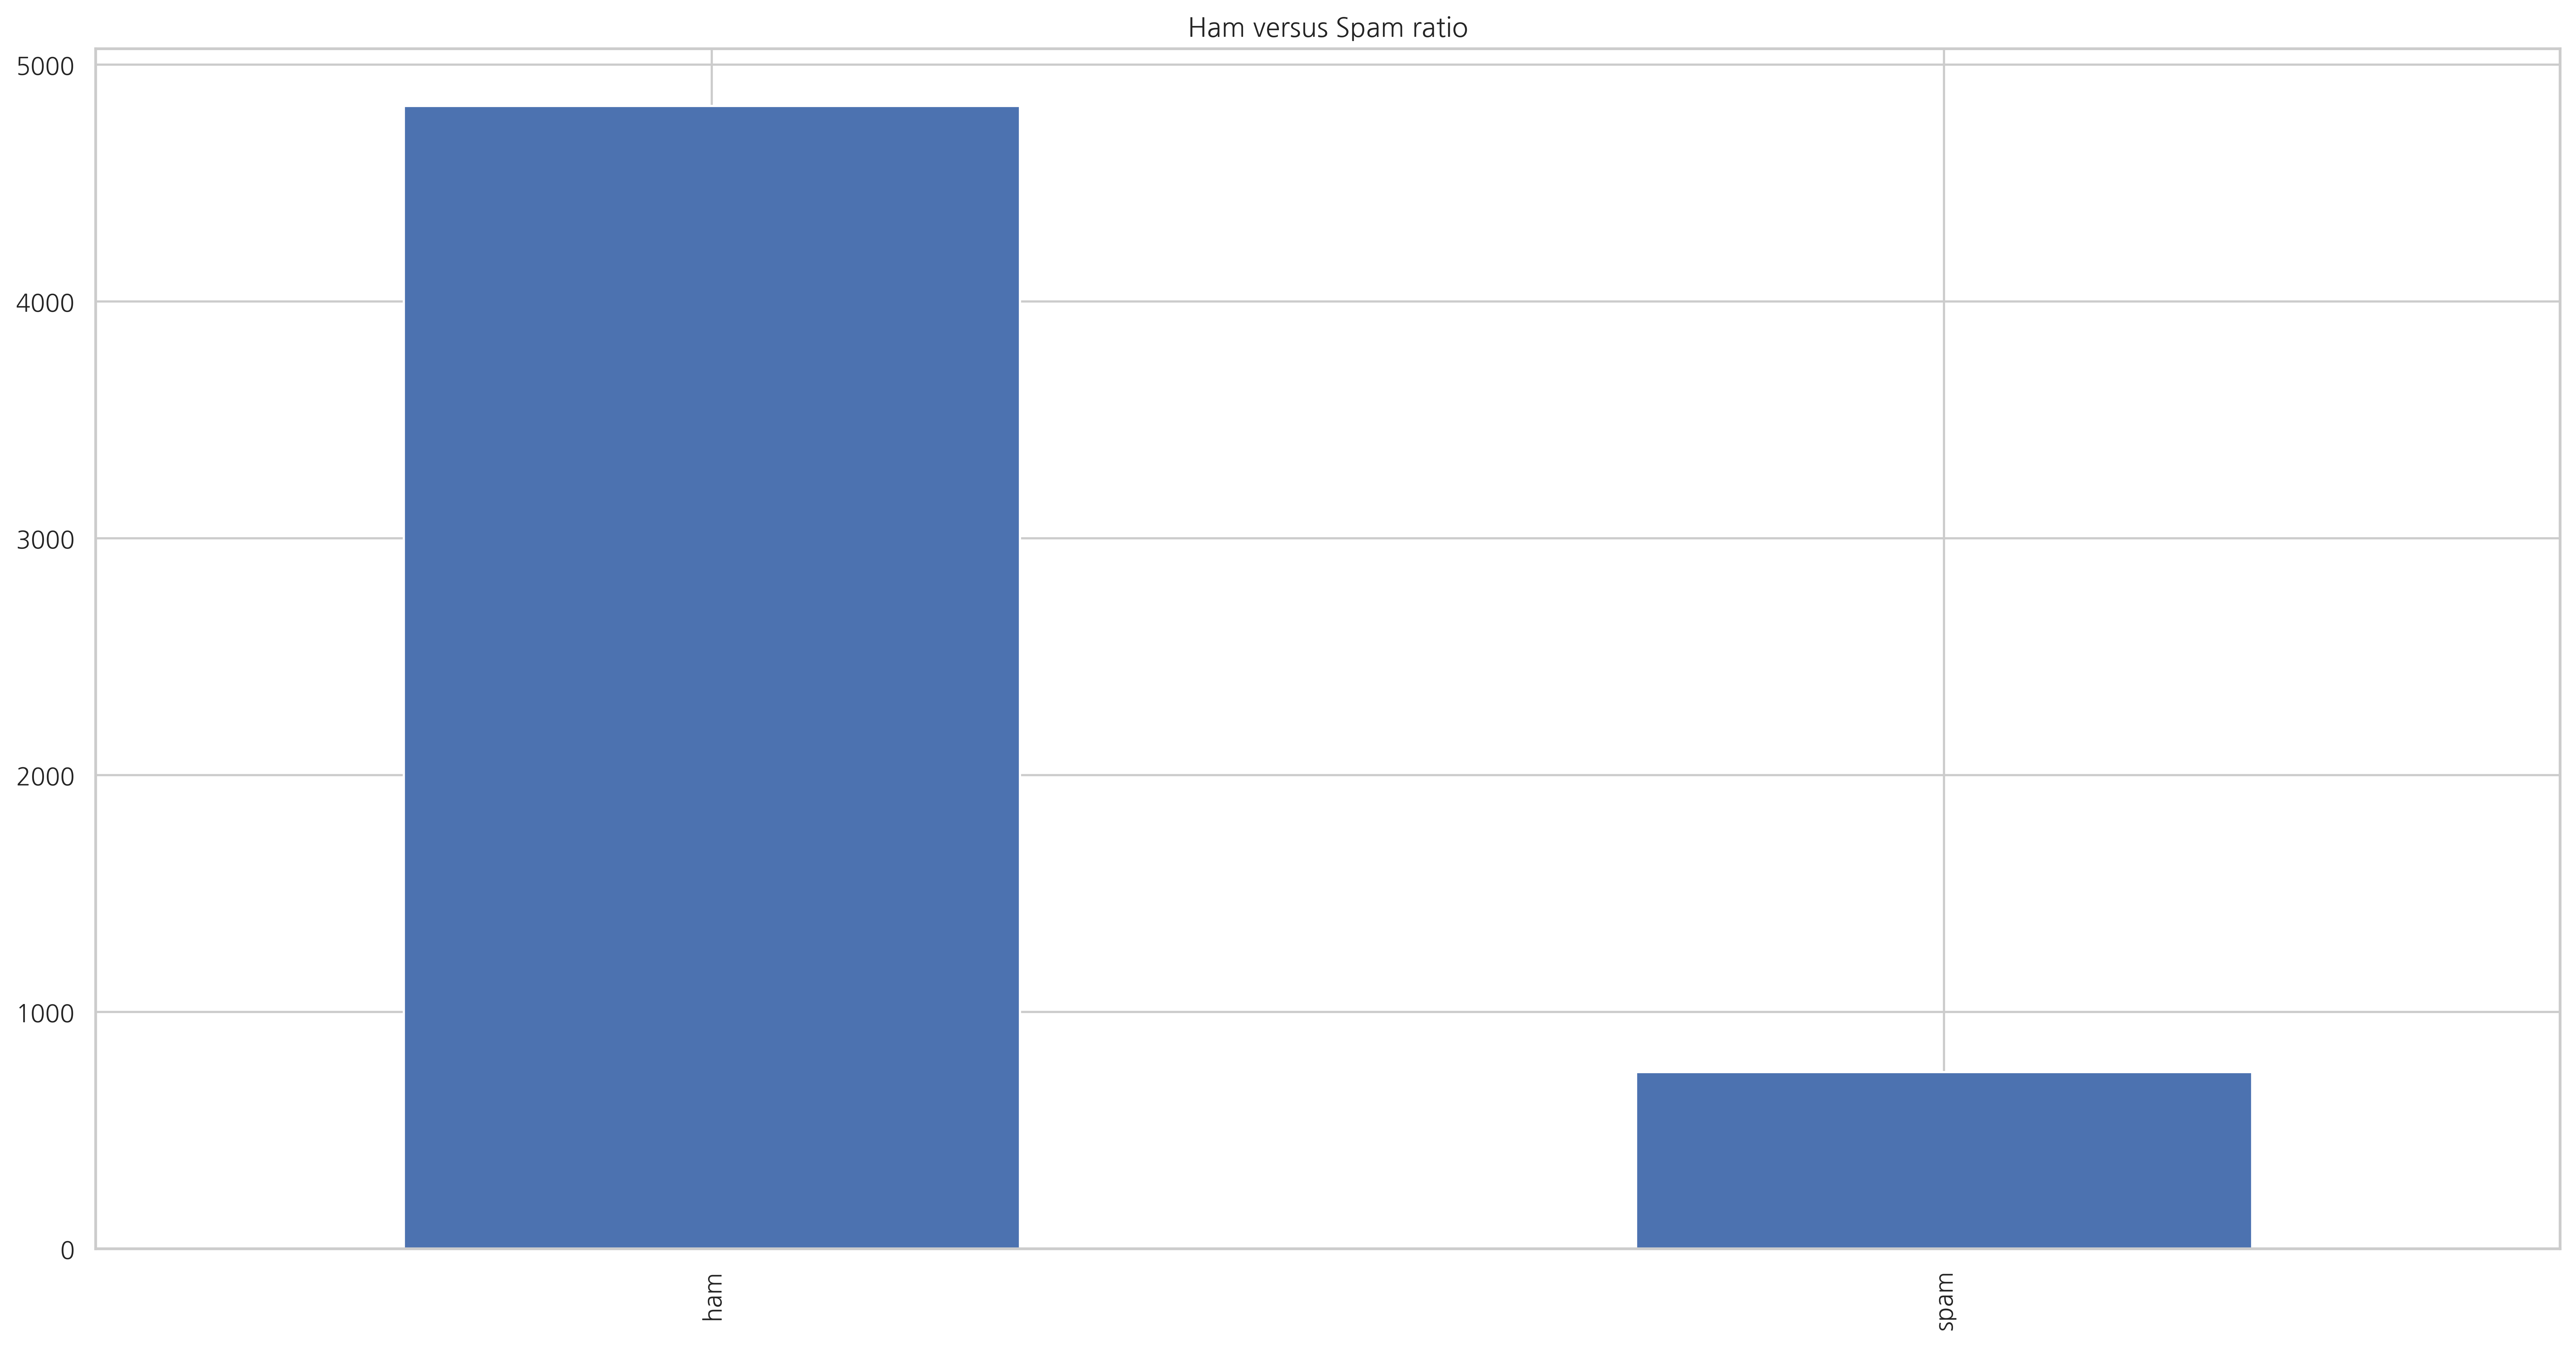

In [45]:
# 비대칭 데이터에선 재현율이 낮을 수 있다는 것을 일단 생각, 정확도엔 문제 없음
plt.figure(figsize=(20, 10))
df['target'].value_counts().plot(kind='bar')
plt.title('Ham versus Spam ratio')
plt.show()

df.groupby('target').count().style.background_gradient(cmap='Blues')

In [46]:
# 불용어 처리
from tensorflow.keras.preprocessing.text import Tokenizer

tk = Tokenizer()
tk.fit_on_texts(X.text)
# total_count는 나중에 모델 생성에도 쓰이게 됨
total_count = len(tk.word_index)
rare_count = 0

for k, v in tk.word_counts.items():
    if (v < 2):
        rare_count = rare_count + 1

print('전체 단어 수 : ', total_count, 
      '희소 단어 수 : ', rare_count)

전체 단어 수 :  8920 희소 단어 수 :  4511


In [47]:
# 빈도 1짜리 단어들은 제외해버림 (전체 단어 - 빈도1짜리 단어 + 1)
tk = Tokenizer(num_words=total_count-rare_count+1)
tk.fit_on_texts(X.text) # 학습
X_data = tk.texts_to_sequences(X.text) # 숫자배열로 인코딩
X_data[0][:5] #일부만 확인

[50, 469, 841, 751, 657]

In [48]:
# 단어장 확인

sent = [None] * 5
for k, v in tk.word_index.items():
    if v == 50:
        sent[0] = k
    if v == 469:
        sent[1] = k
    if v == 841:
        sent[2] = k
    if v == 751:
        sent[3] = k
    if v == 657:
        sent[4] = k
print(sent)

['go', 'until', 'point', 'crazy', 'available']


In [49]:
# 스팸메일 등장빈도 top5
# 스팸메일과 햄메일 사이에 단어 등장 패턴이 달라야 분류가 가능
X_spam = df[df['target'] == 'spam']['text']
tk2 = Tokenizer()
tk2.fit_on_texts(X_spam)
sequences = tk2.texts_to_sequences(X_spam)
rank5 = sorted(tk2.word_counts.items(), key=lambda item: item[1], reverse=True)[:5]

print('스팸메일 어휘 등장 빈도 Top 5')
for i, (w, f) in enumerate(rank5):
    print('{}위 : '.format(i+1) + w, f)

스팸메일 어휘 등장 빈도 Top 5
1위 : to 688
2위 : a 377
3위 : call 355
4위 : you 290
5위 : your 264


In [50]:
# 햄메일 등장빈도 top 5
X_ham = df[df['target'] == 'ham']['text']
tk2 = Tokenizer()
tk2.fit_on_texts(X_ham)
sequences = tk2.texts_to_sequences(X_ham)
rank5 = sorted(tk2.word_counts.items(), key=lambda item: item[1], reverse=True)[:5]

print('햄메일 어휘 등장 빈도 Top 5')
for i, (w, f) in enumerate(rank5):
    print('{}위 : '.format(i+1) + w, f)

햄메일 어휘 등장 빈도 Top 5
1위 : i 2301
2위 : you 1860
3위 : to 1554
4위 : the 1122
5위 : a 1056


최대 단어 수 :  183
평균 단어 수 :  14.985283560660445
----------------------------------------------------------------------------------------------------


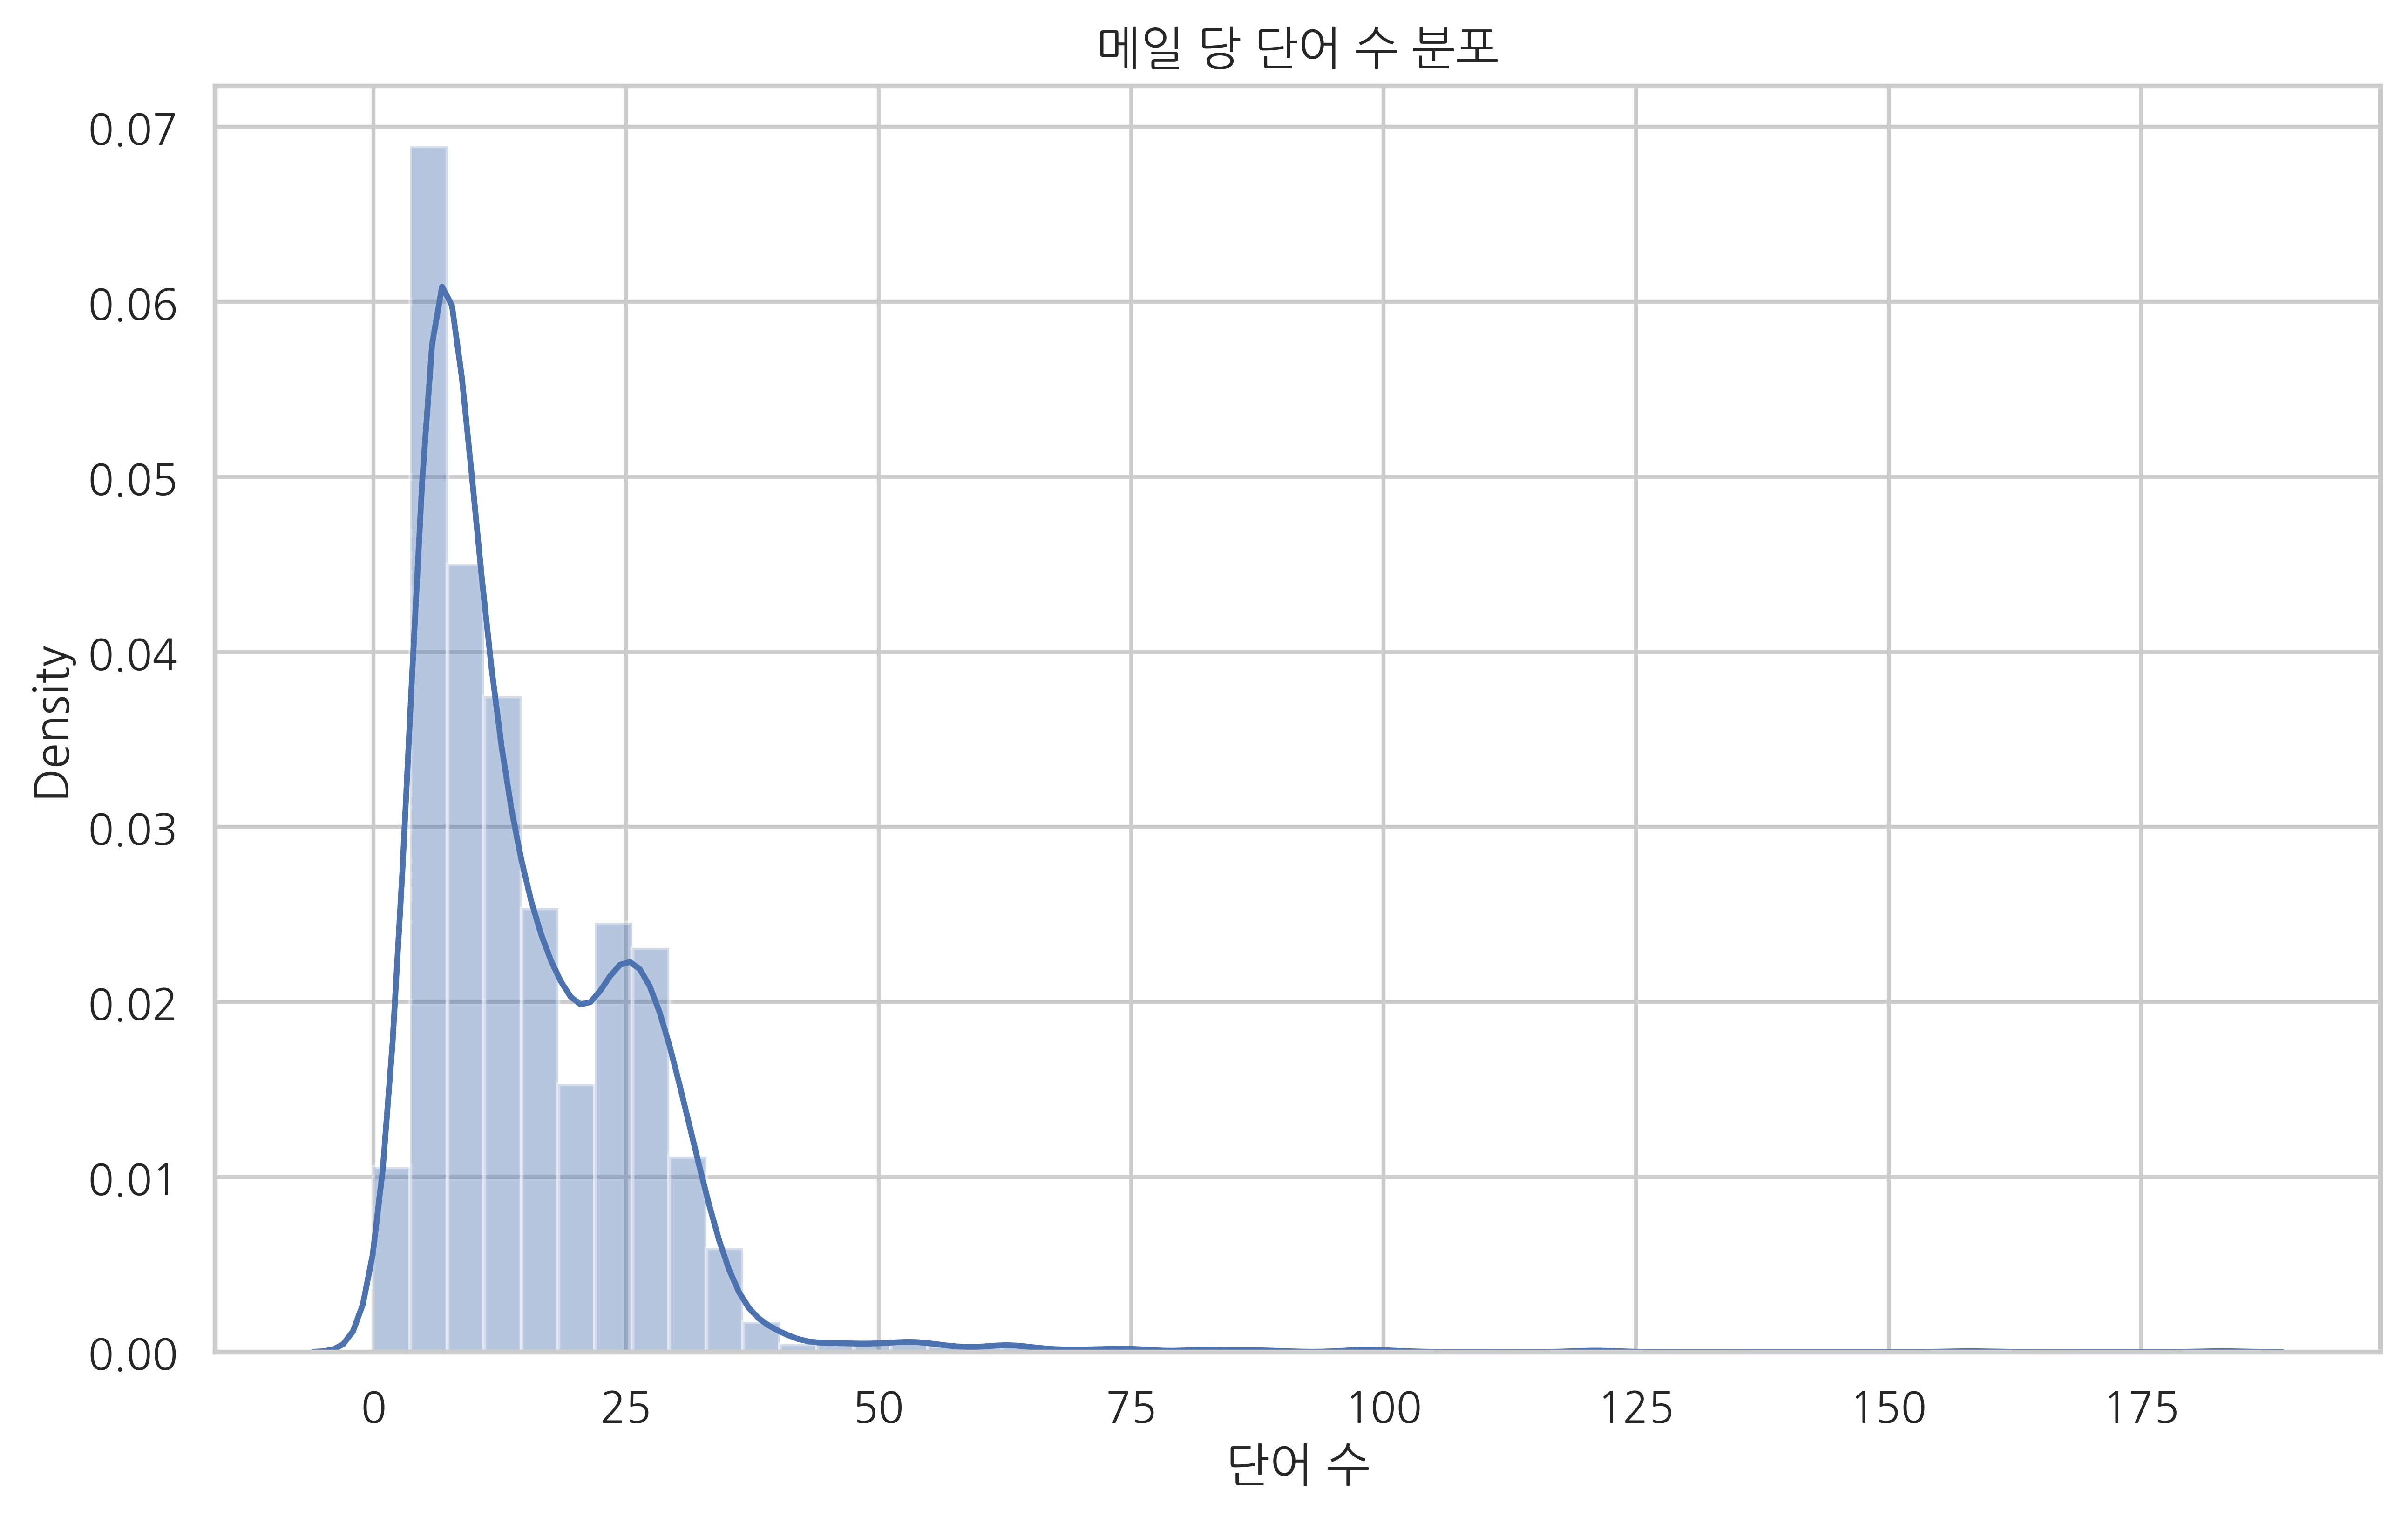

In [51]:
# 시각화
mail_length = [len(x) for x in X_data] # 중복이 좀 많음

print('최대 단어 수 : ', np.max(mail_length))
print('평균 단어 수 : ', np.mean(mail_length))
print('-' * 100)

plt.figure(figsize=(10, 6))
sns.distplot(mail_length, bins=50)
plt.title('메일 당 단어 수 분포')
plt.xlabel('단어 수')
plt.show()

In [344]:
# 마지막 준비
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 모델에 입력될 때 데이터의 특성의 개수가 각각 다르면 안되기 때문에
# 차원이 작은 데이터를 패딩해주게됨
X = pd.DataFrame(pad_sequences(X_data, maxlen=183))
# 하는 김에 y도 변환
y.target = y.target.factorize()[0]
y

target
0          0
1          0
2          1
3          0
4          0
...      ...
5567       1
5568       0
5569       0
5570       0
5571       0

[5572 rows x 1 columns]

### 머신러닝

In [53]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense


model = Sequential()
model.add(Embedding(total_count, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
# rmsprop: Adagrad의 개선된 버전(속도가 늘어날 수 있음)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, None, 32)          285440    
_________________________________________________________________
simple_rnn_31 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 33        
Total params: 287,553
Trainable params: 287,553
Non-trainable params: 0
_________________________________________________________________


In [120]:
print('embedding : ', 8920 * 32)
# 이전 출력층과 연결 + 이전 출력층과 연결 + 편향
print('simple_rnn : ', (32 * 32) + (32 * 32) + 32)
print('dense : ', 32 * 1 + 1)

embedding :  285440
simple_rnn :  2080
dense :  33


In [121]:
epochs = 10
history = model.fit(train_X, train_y, epochs=epochs, validation_split=0.2, batch_size=64, verbose=0)

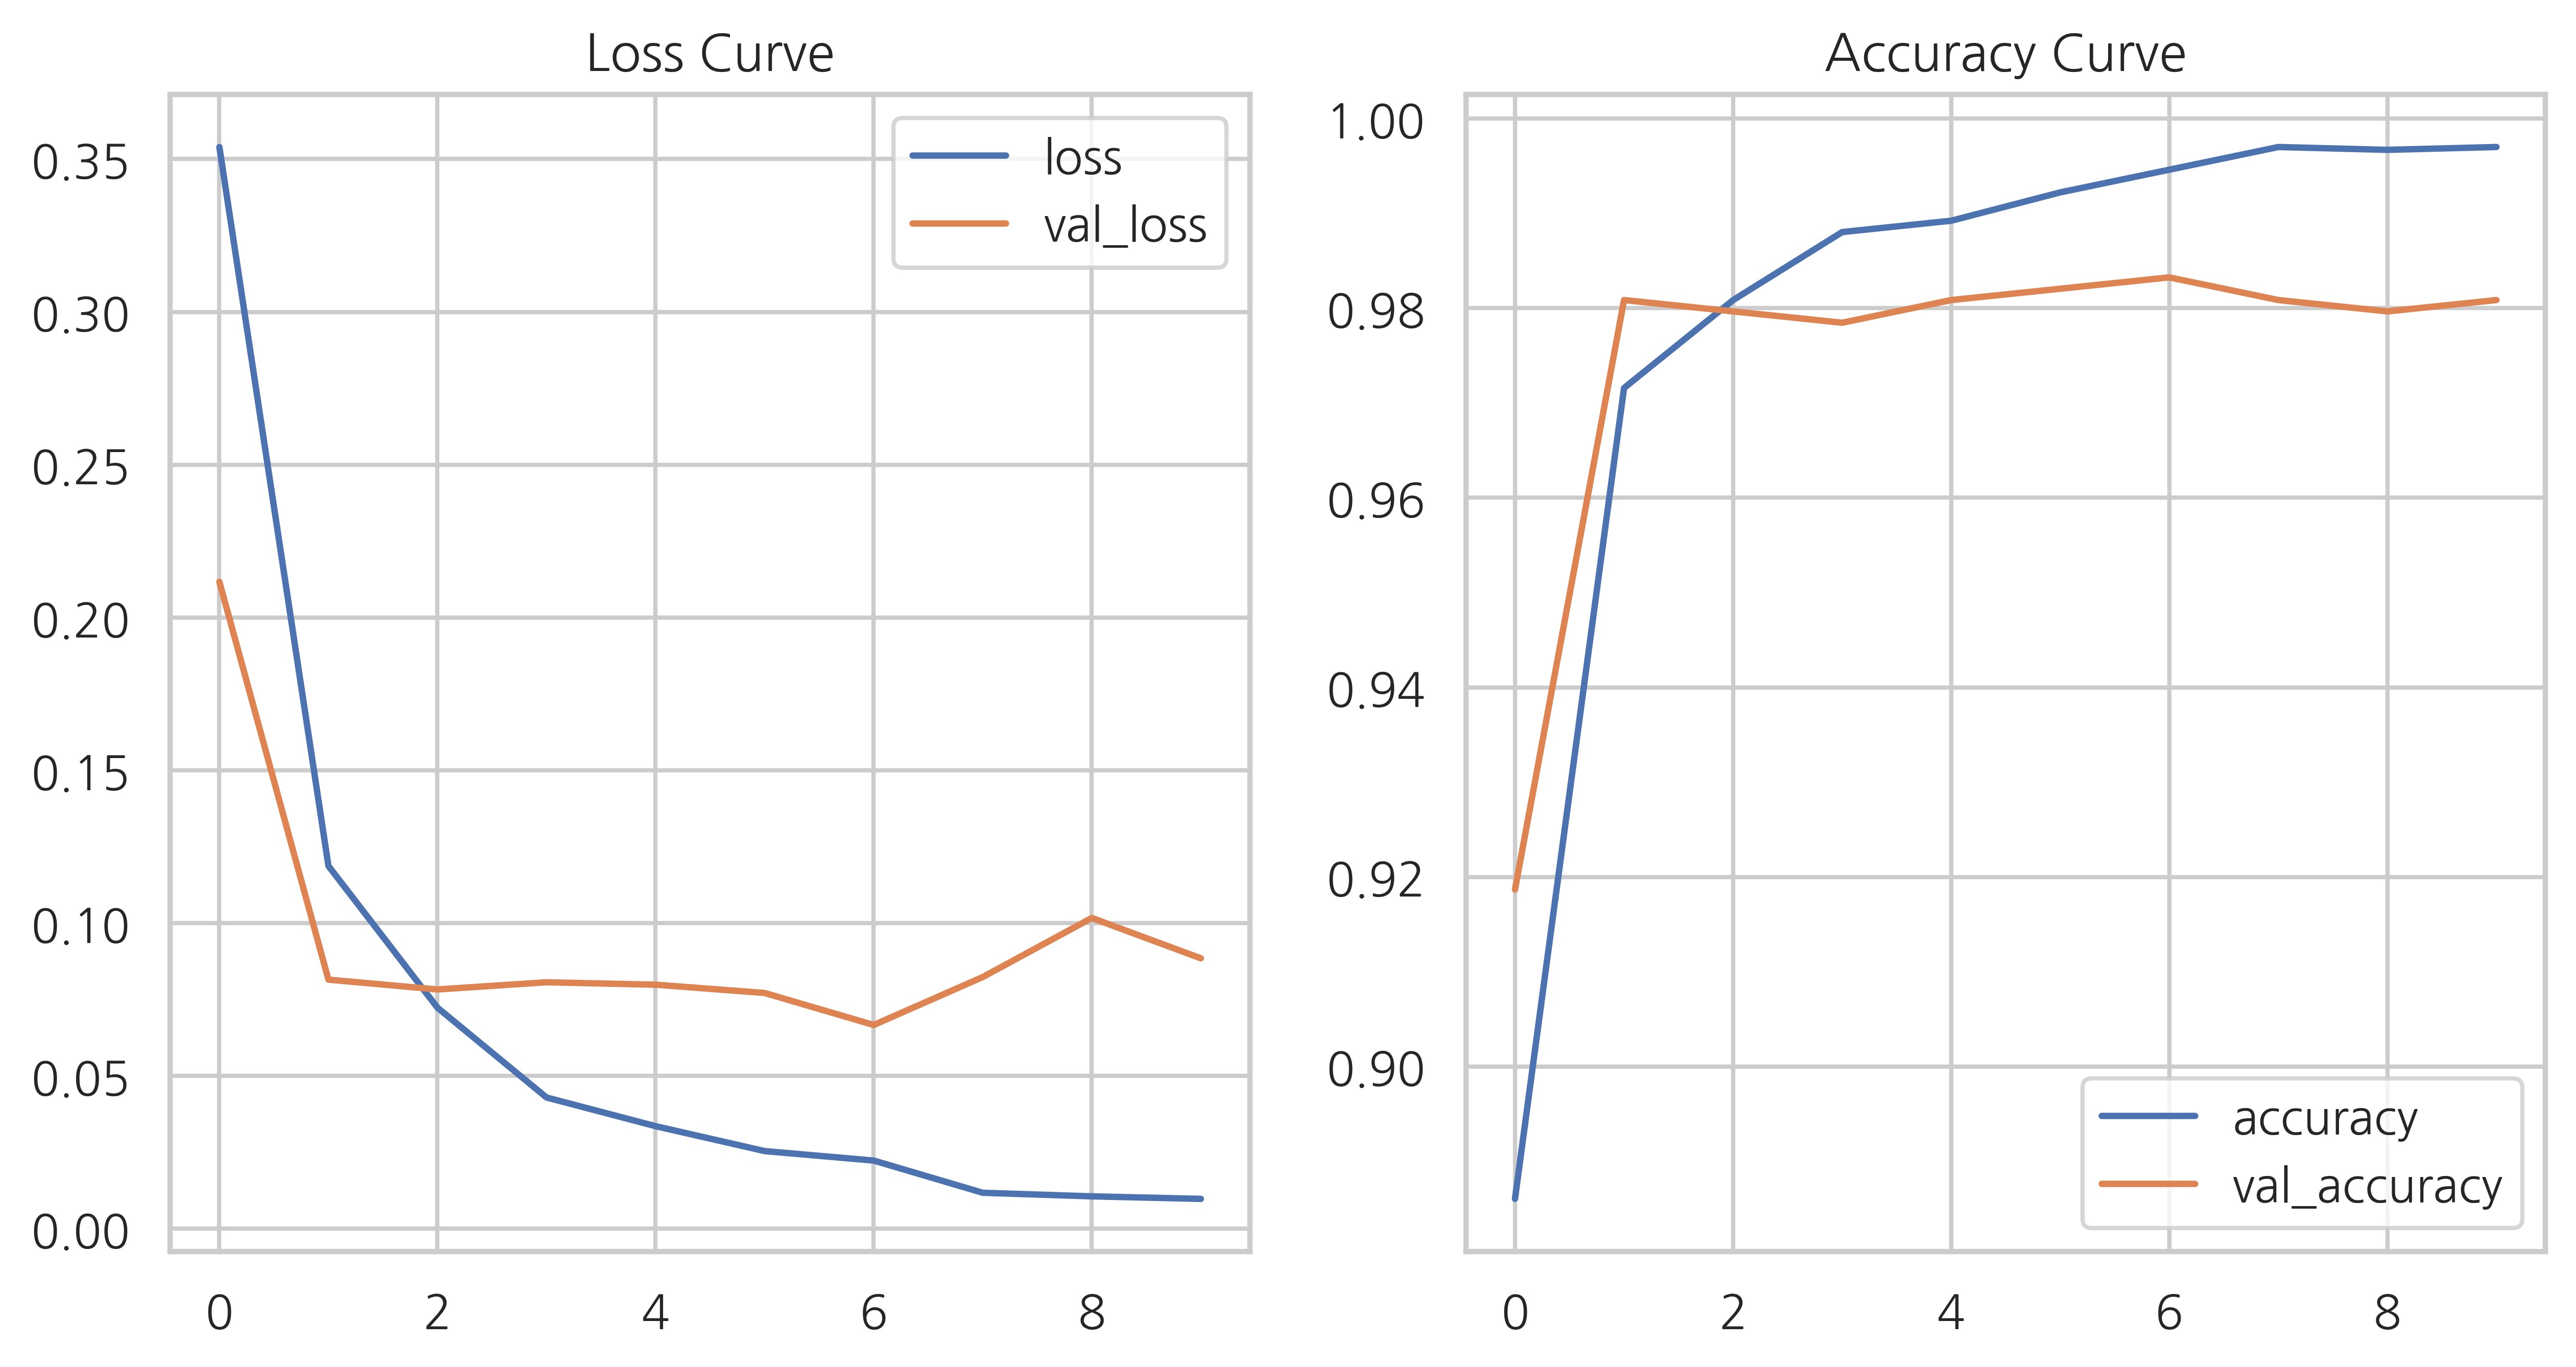

In [122]:
def plot_curve():
    f, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(history.history['loss'], label='loss')
    axs[0].plot(history.history['val_loss'], label='val_loss')
    axs[0].legend()
    axs[0].set_title('Loss Curve')
    axs[1].plot(history.history['accuracy'], label='accuracy')
    axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
    axs[1].legend()
    axs[1].set_title('Accuracy Curve')
    plt.show()
plot_curve()

In [129]:
model = Sequential()
model.add(Embedding(total_count, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 3
history = model.fit(train_X, train_y, epochs=epochs, validation_split=0.2, batch_size=64)

Epoch 1/3
53/53 [==============================] - 3s 34ms/step - loss: 0.5762 - accuracy: 0.6563 - val_loss: 0.2620 - val_accuracy: 0.9557
Epoch 2/3
53/53 [==============================] - 2s 32ms/step - loss: 0.1783 - accuracy: 0.9601 - val_loss: 0.0993 - val_accuracy: 0.9749
Epoch 3/3
53/53 [==============================] - 2s 32ms/step - loss: 0.0964 - accuracy: 0.9726 - val_loss: 0.1050 - val_accuracy: 0.9665


In [134]:
from sklearn.metrics import classification_report, accuracy_score

mus = model.predict(test_X)
y_pred = [np.where(mu >= 0.5, 1, 0) for mu in mus]
print(classification_report(test_y, y_pred))
print('-' * 100)
print('정확도 : ', accuracy_score(test_y, y_pred))
# 준수한 accuracy이지만 recall_rate는 아까 말했듯 낮은 수치

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1196
           1       0.99      0.68      0.81       197

    accuracy                           0.95      1393
   macro avg       0.97      0.84      0.89      1393
weighted avg       0.96      0.95      0.95      1393

----------------------------------------------------------------------------------------------------
정확도 :  0.9540559942569993


### 비대칭 데이터

In [154]:
train_X.shape, train_y.shape

((4179, 183), (4179, 1))

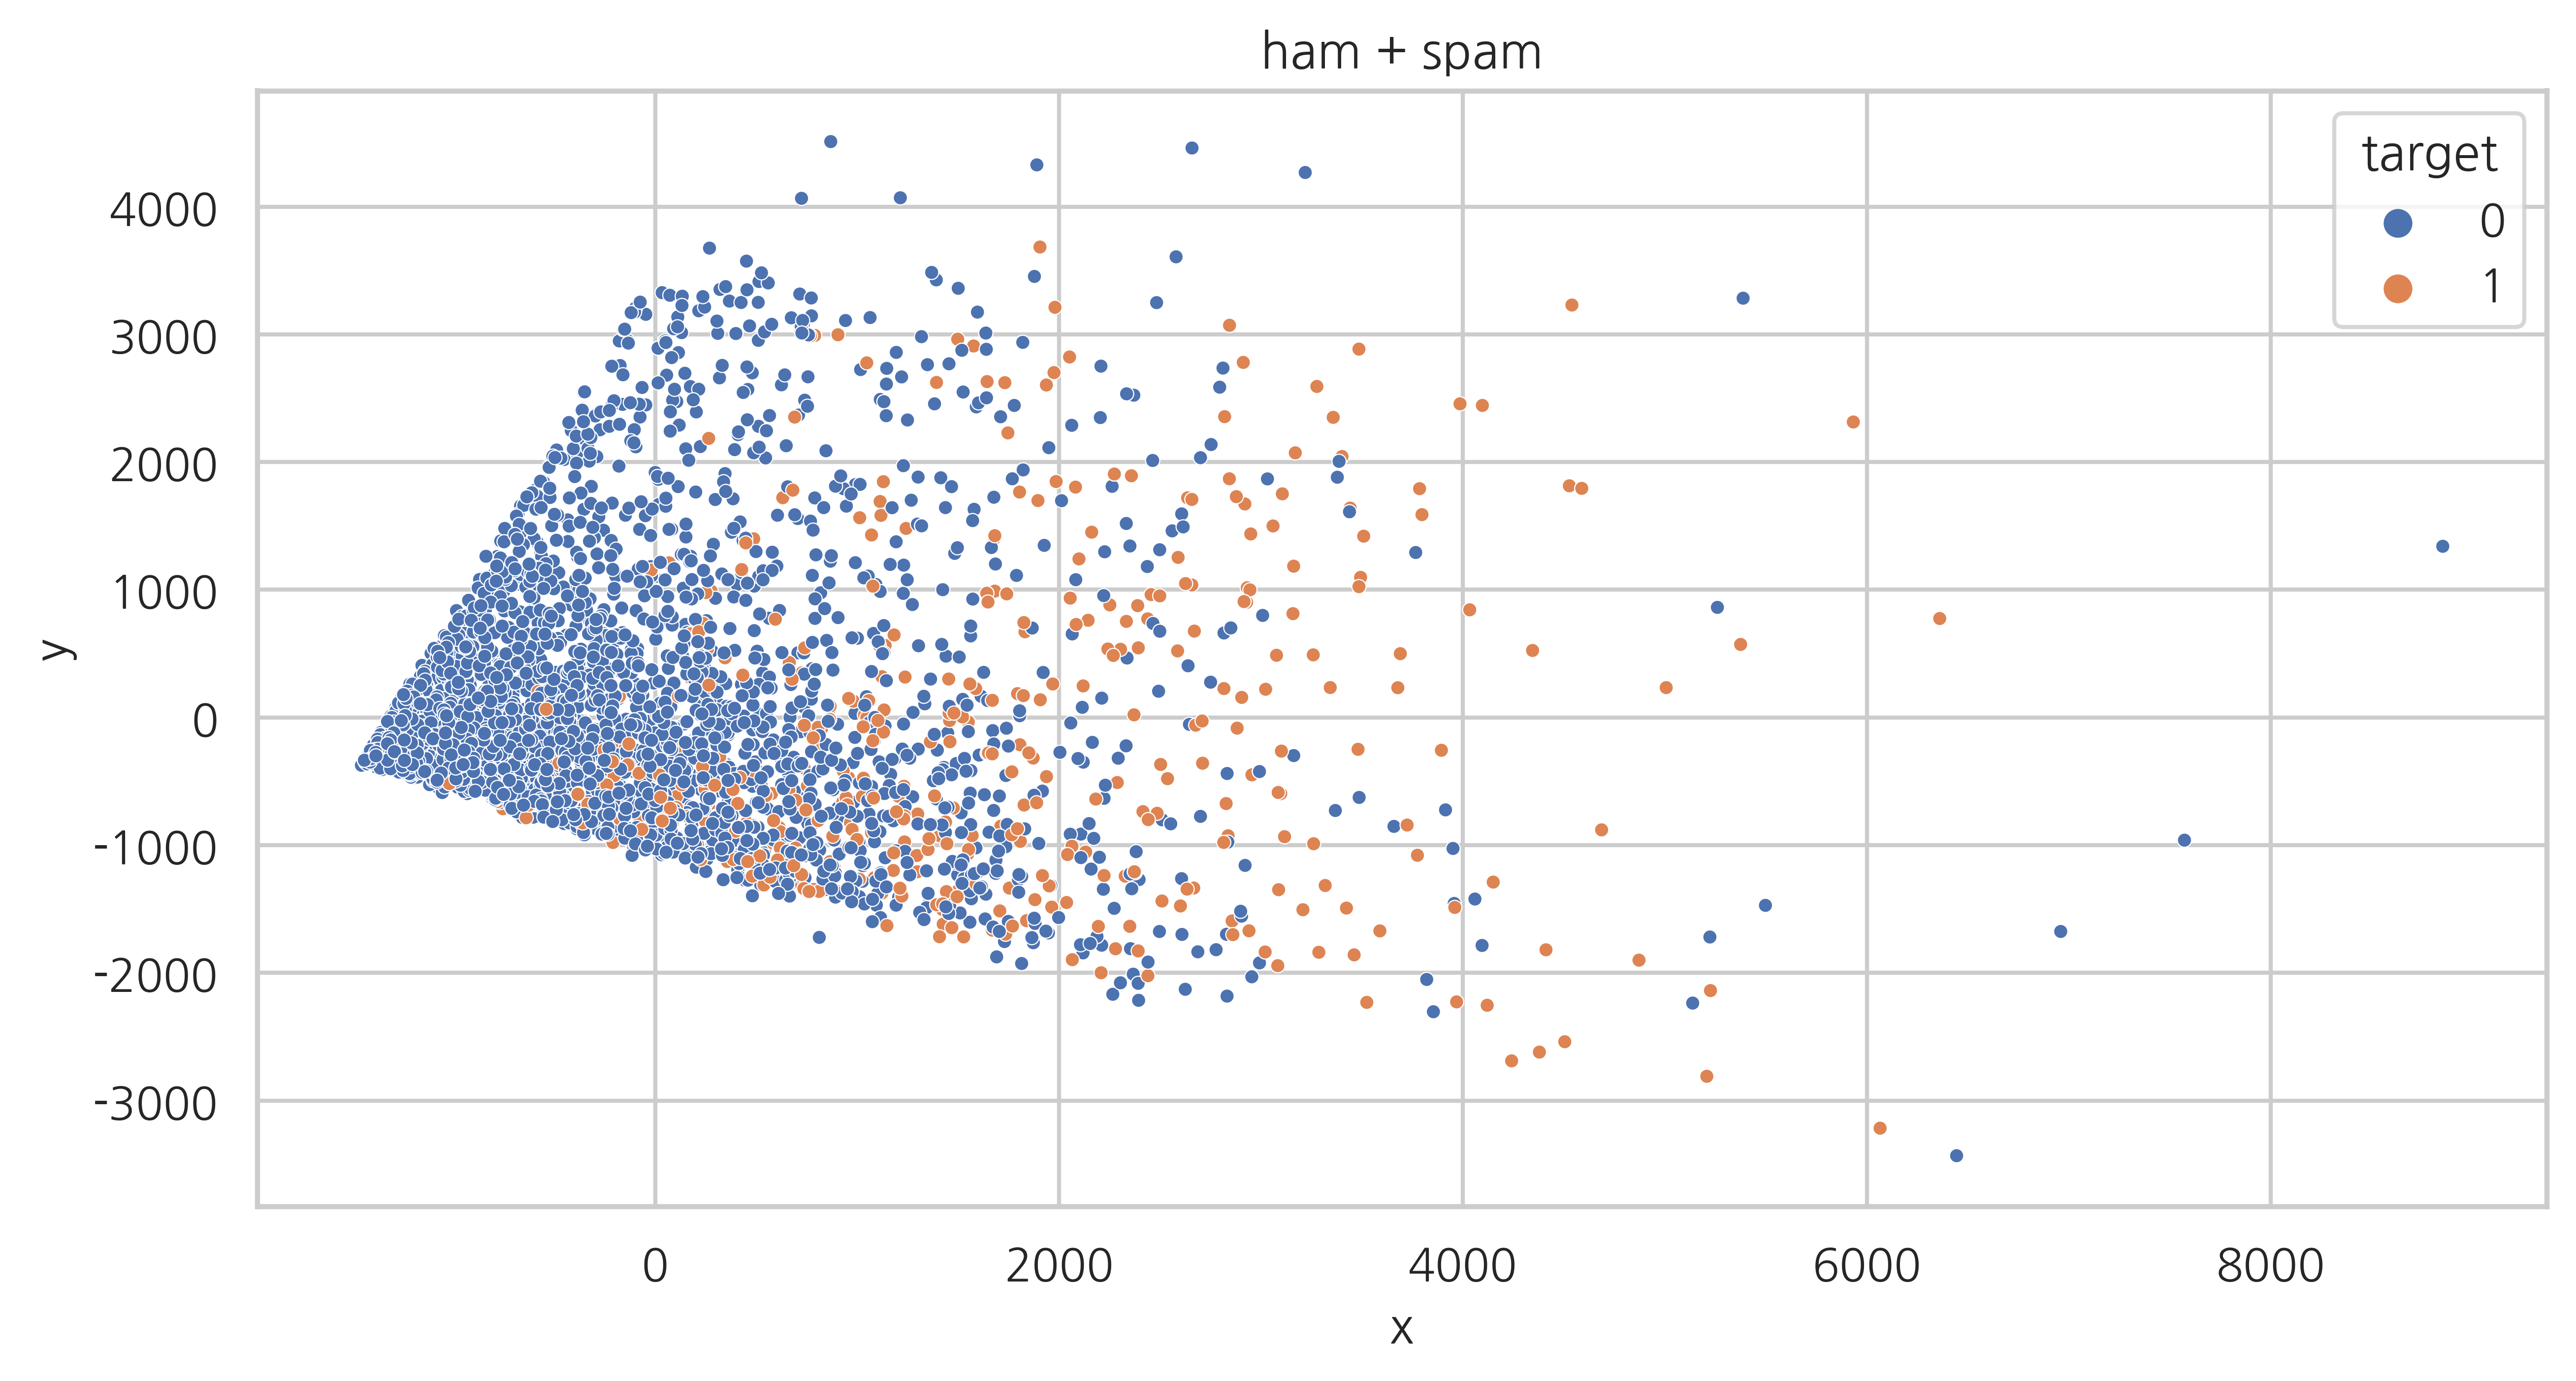

In [334]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)
X_2d = pca.fit_transform(train_X)
X_2d = pd.DataFrame(X_2d, columns=['x', 'y'])


df_2d = pd.concat([X_2d, train_y.reset_index(drop=True)], axis=1)

mask0 = df_2d['target'] == 0
mask0 = df_2d['target'] == 1

plt.figure(figsize=(10, 5))
sns.scatterplot(x='x', y='y', data=df_2d, hue='target', s=12)
plt.title('ham + spam')
plt.show()

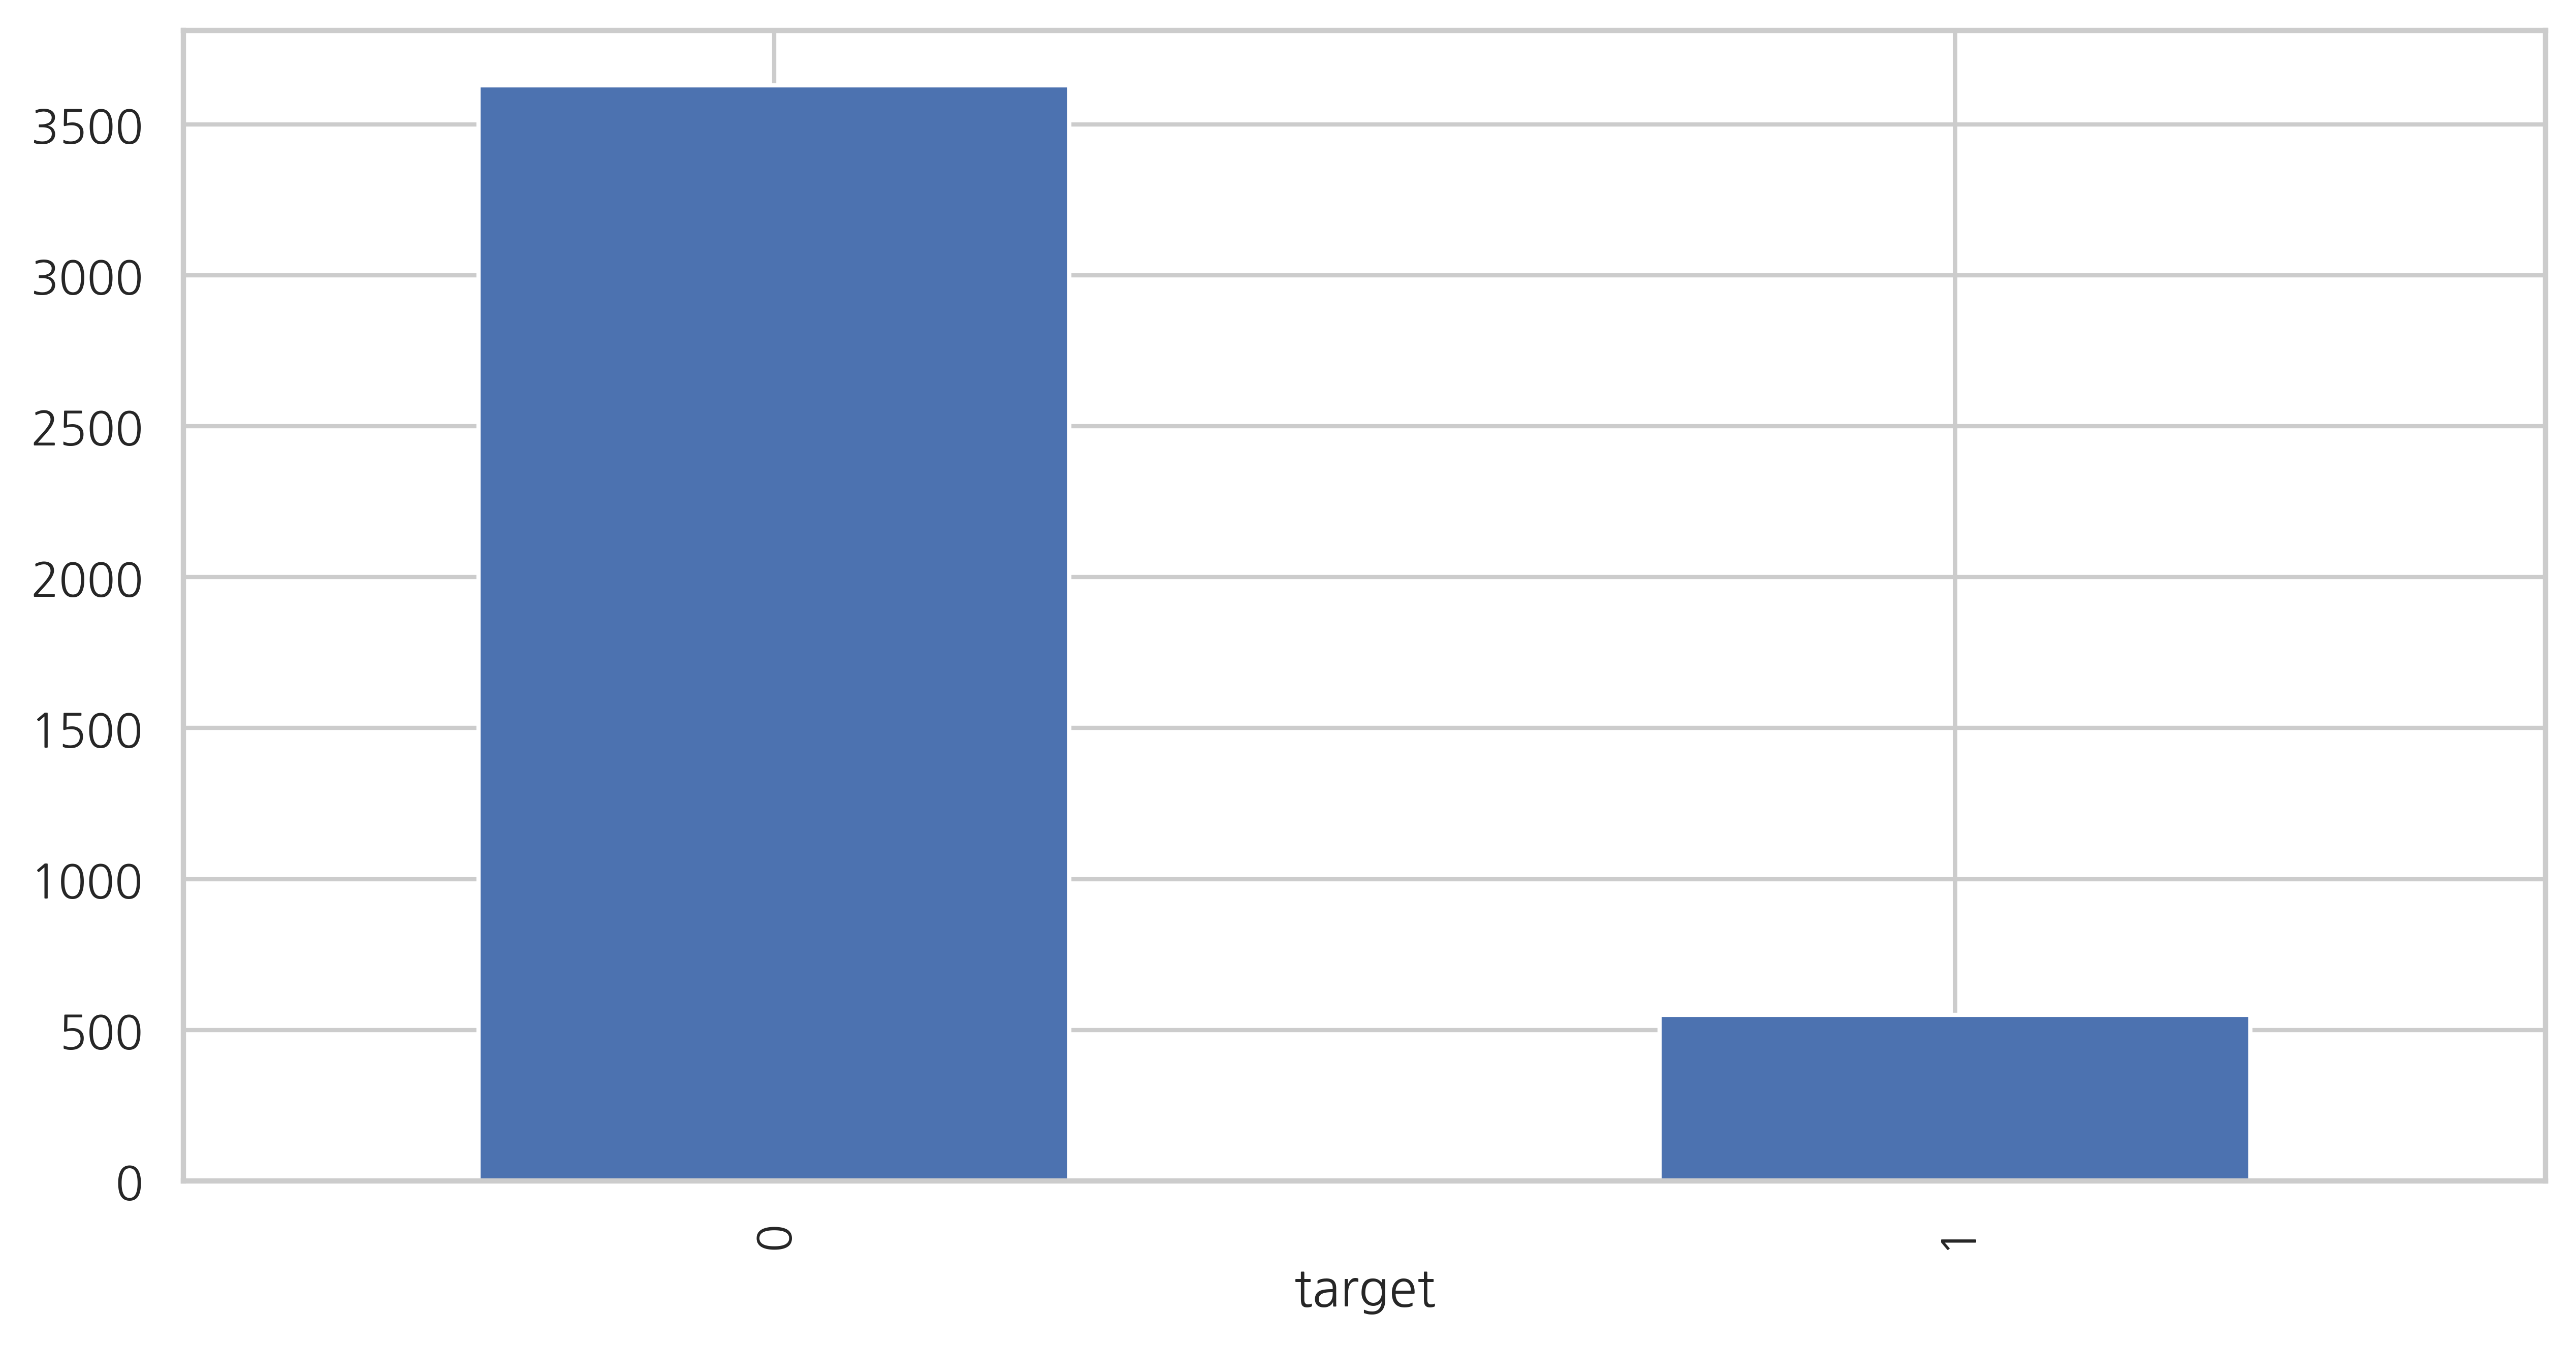

In [335]:
plt.figure(figsize=(10, 5))
df_2d.groupby('target').size().plot(kind='bar')
plt.show()

Epoch 1/10
91/91 [==============================] - 5s 36ms/step - loss: 0.4664 - accuracy: 0.7848 - val_loss: 0.4338 - val_accuracy: 0.8134
Epoch 2/10
91/91 [==============================] - 3s 29ms/step - loss: 0.3665 - accuracy: 0.8561 - val_loss: 0.3636 - val_accuracy: 0.8485
Epoch 3/10
91/91 [==============================] - 3s 31ms/step - loss: 0.1312 - accuracy: 0.9595 - val_loss: 0.4106 - val_accuracy: 0.8264
Epoch 4/10
91/91 [==============================] - 4s 49ms/step - loss: 0.0919 - accuracy: 0.9708 - val_loss: 0.4037 - val_accuracy: 0.8492
Epoch 5/10
91/91 [==============================] - 4s 40ms/step - loss: 0.0588 - accuracy: 0.9834 - val_loss: 0.7849 - val_accuracy: 0.7259
Epoch 6/10
91/91 [==============================] - 5s 52ms/step - loss: 0.0513 - accuracy: 0.9847 - val_loss: 0.2778 - val_accuracy: 0.8939
Epoch 7/10
91/91 [==============================] - 5s 52ms/step - loss: 0.0262 - accuracy: 0.9931 - val_loss: 0.2379 - val_accuracy: 0.9167
Epoch 8/10
91

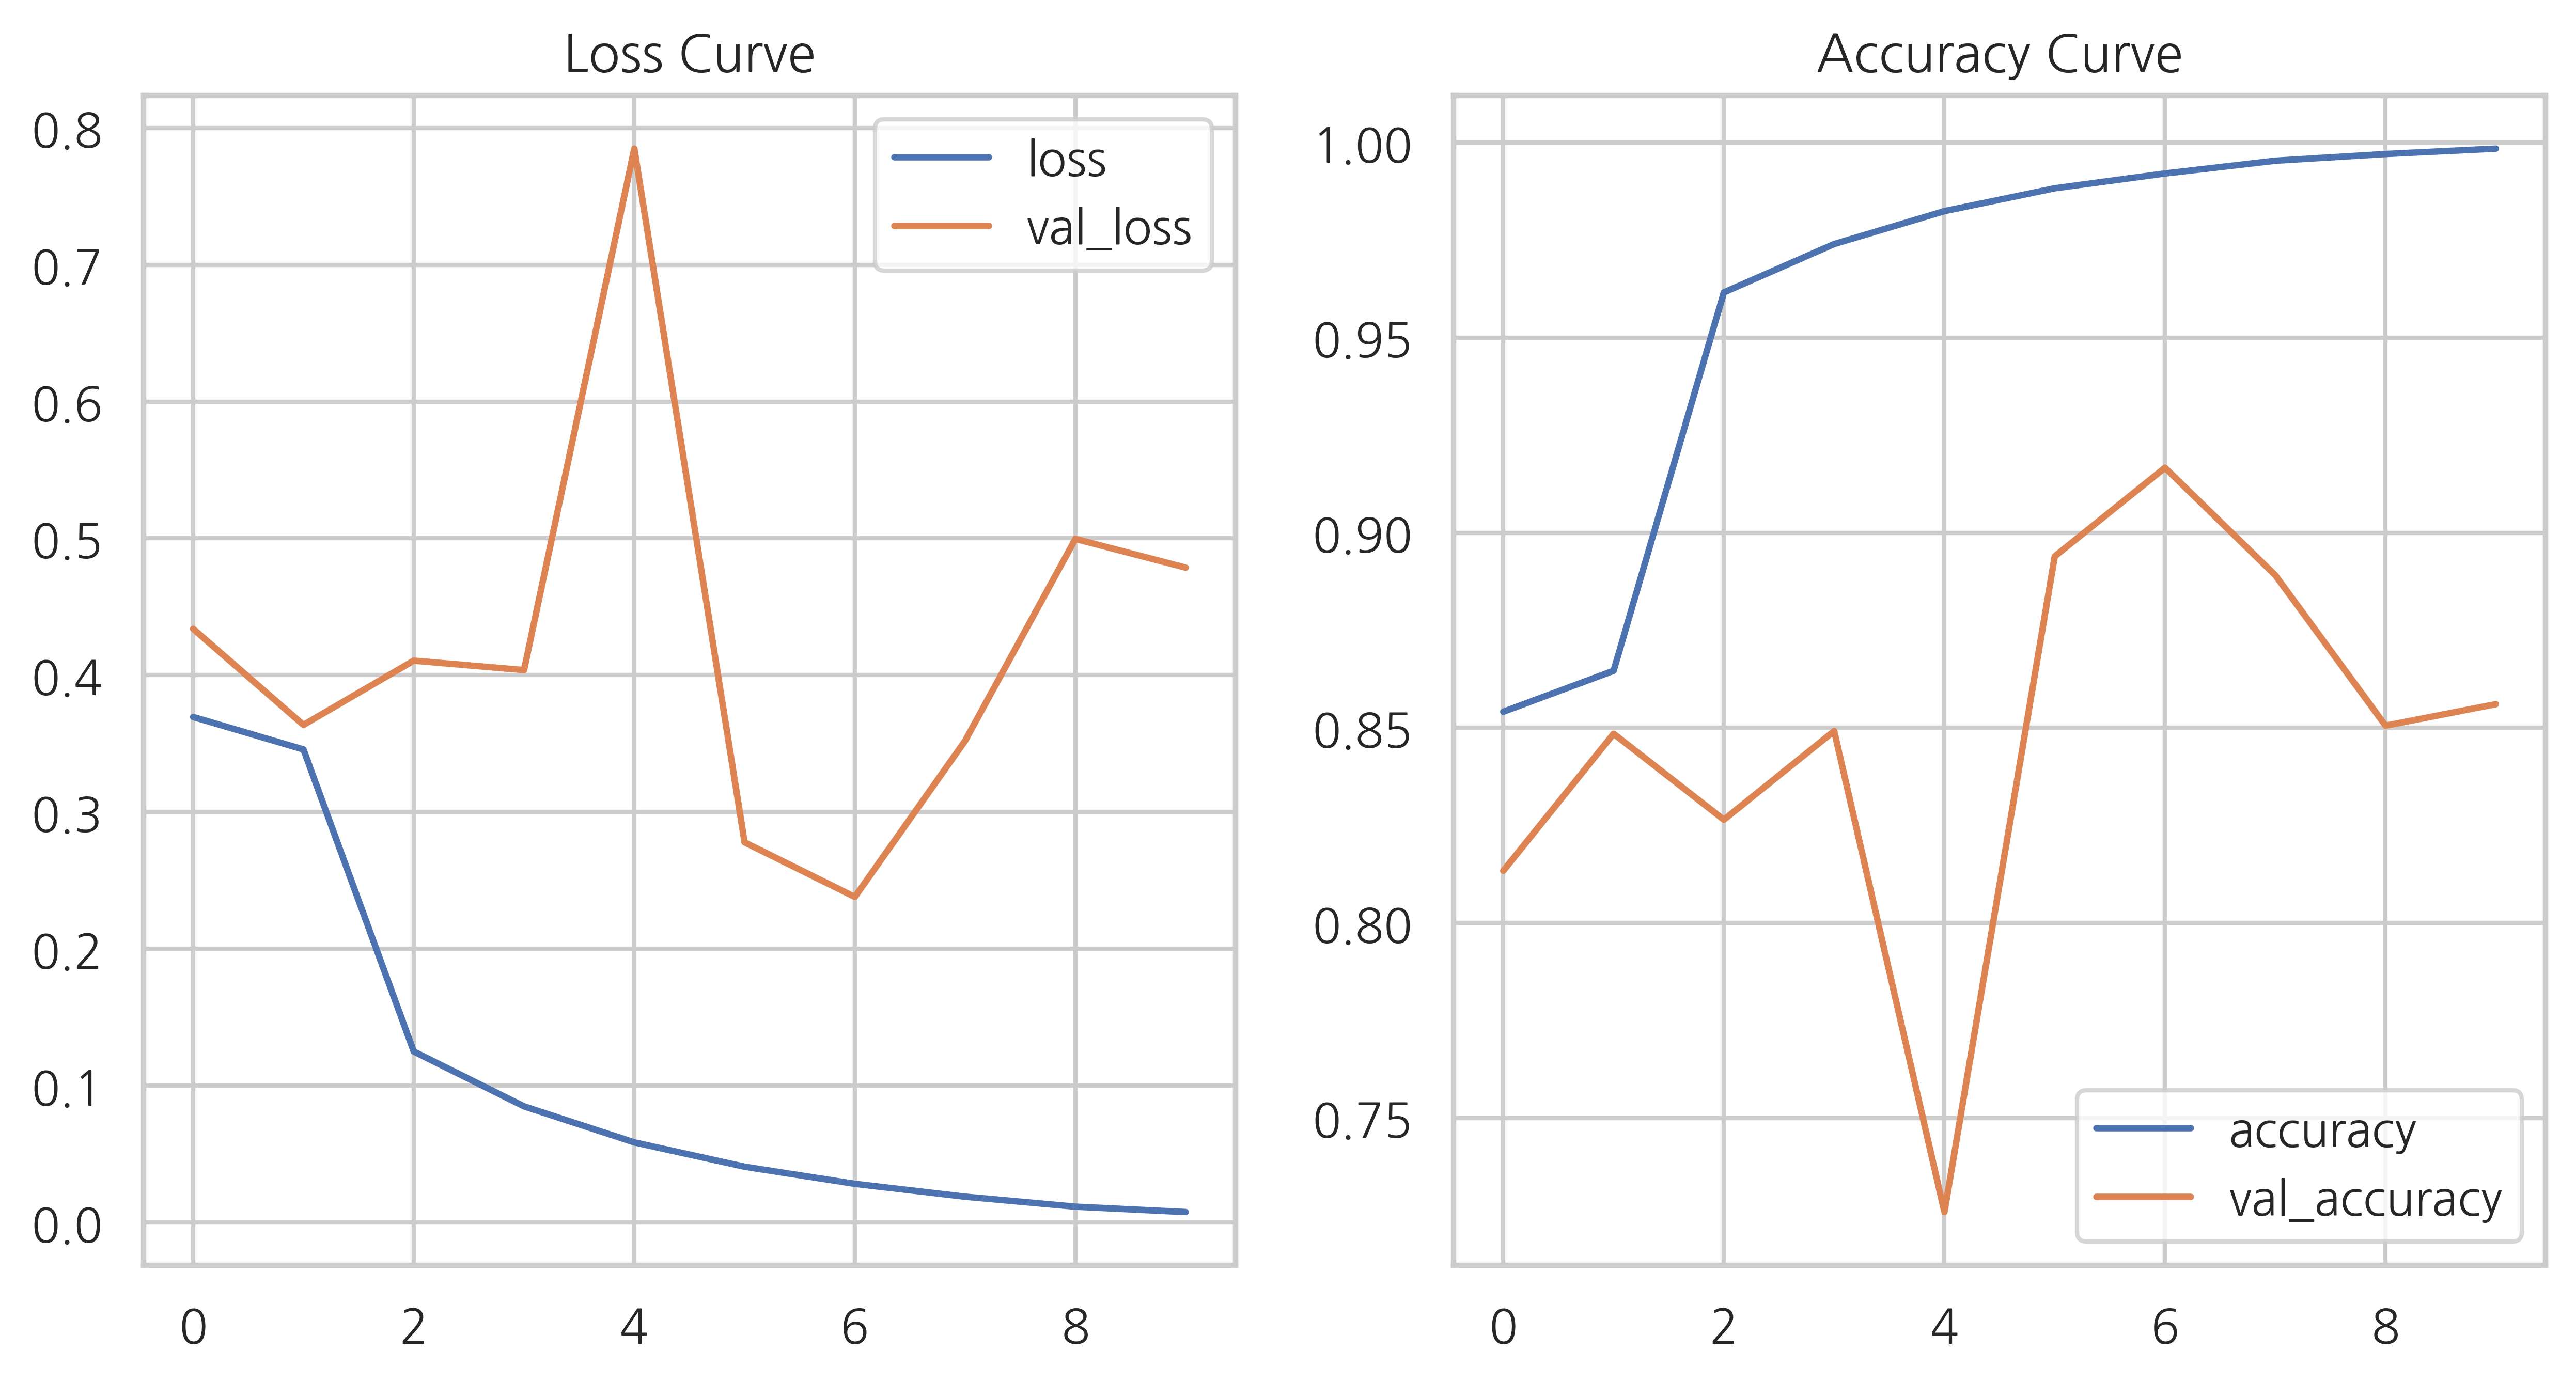

In [300]:
from imblearn.over_sampling import *
from tensorflow.keras.regularizers import l2

# 오버샘플링 기법을 이용
blcd_X, blcd_y = SMOTE(random_state=0).fit_resample(train_X, train_y)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense

model = Sequential()
model.add(Embedding(total_count, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
# rmsprop: Adagrad의 개선된 버전(속도가 늘어날 수 있음)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10
history = model.fit(blcd_X, blcd_y, epochs=epochs, validation_split=0.2, batch_size=64)

plot_curve()

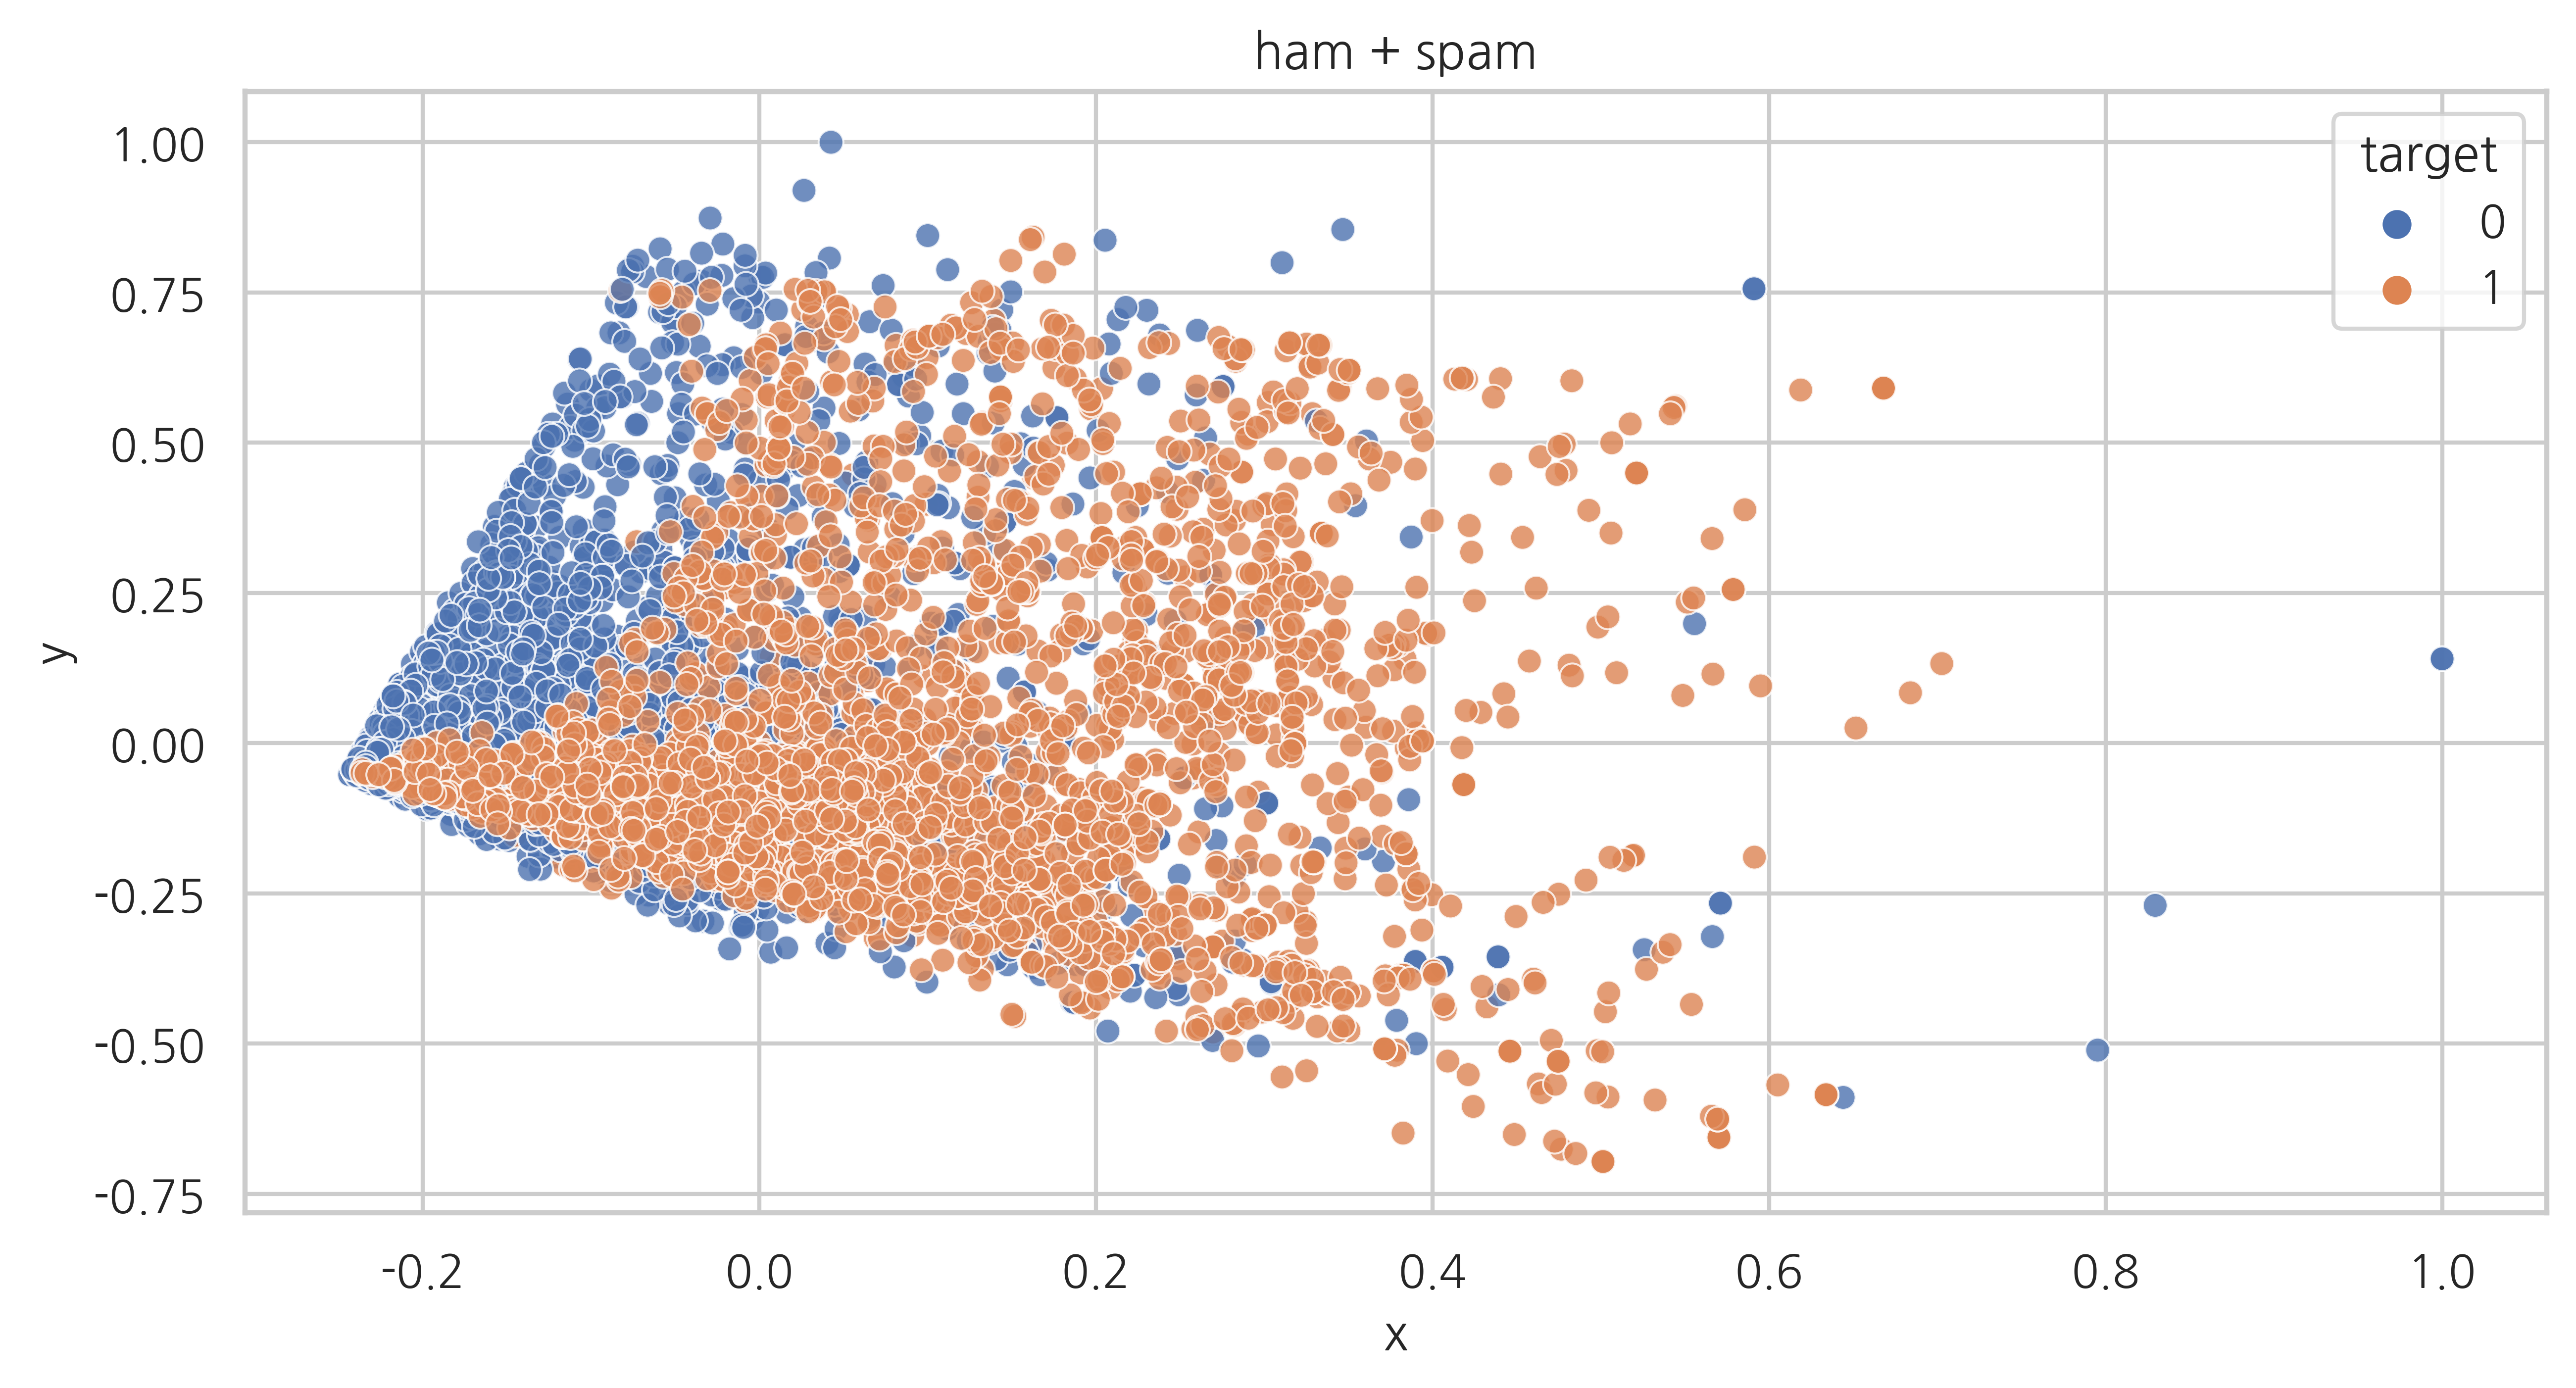

In [321]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(blcd_X)
X_2d = pd.DataFrame(MaxAbsScaler().fit_transform(X_2d), columns=['x', 'y'])

df_2d = pd.concat([X_2d, blcd_y.reset_index(drop=True)], axis=1)

plt.figure(figsize=(10, 5))
sns.scatterplot(x='x', y='y', data=df_2d, hue='target', alpha=0.8)
plt.title('ham + spam')
plt.show()

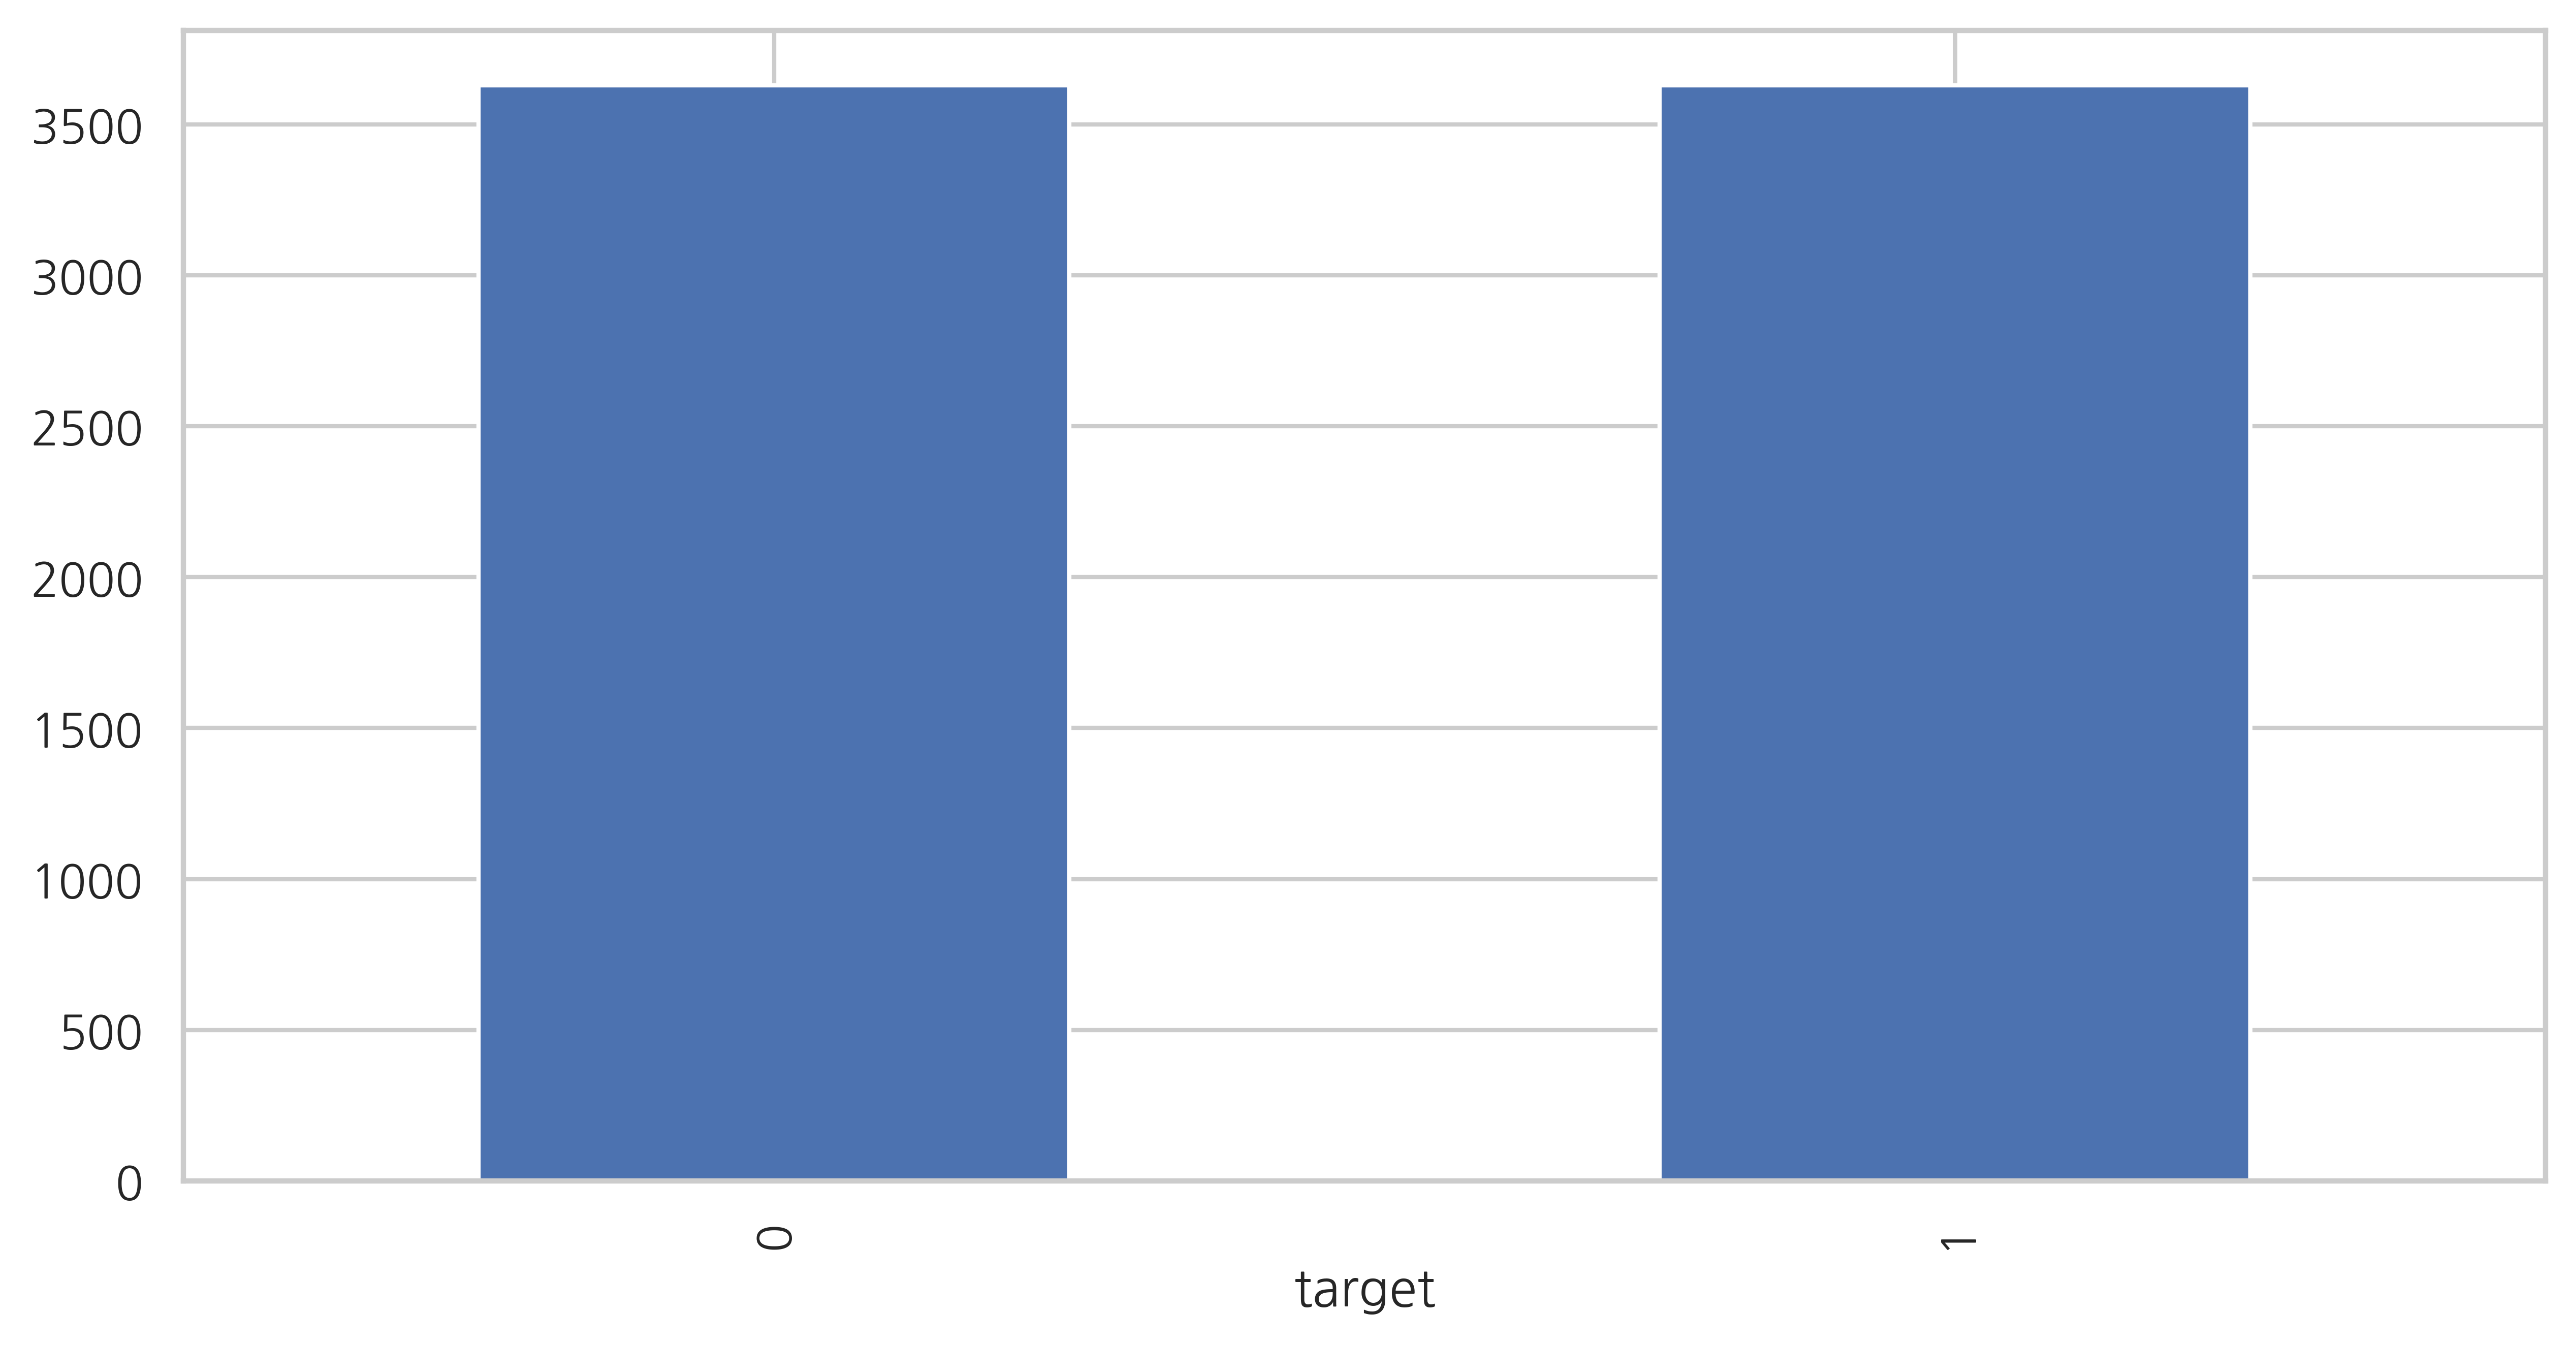

In [333]:
plt.figure(figsize=(10, 5))
df_2d.groupby('target').size().plot(kind='bar')
plt.show()

In [325]:
mus = model.predict(test_X)
y_pred = [np.where(mu >= 0.5, 1, 0) for mu in mus]
print(classification_report(test_y, y_pred))
# 재현율이 매우 상승

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1196
           1       0.76      0.97      0.86       197

    accuracy                           0.95      1393
   macro avg       0.88      0.96      0.91      1393
weighted avg       0.96      0.95      0.96      1393



In [444]:
text = '''
How are you doing today? I am Mr. Fong pau teck a staff of a reputable financial institution here in Malaysia.
An investment was placed under my management. I need your assistance in investing the fund in your country into a good business.
If you are interested reply back, so I can forward you with more details.
'''

def predict_spam(text):
    from math import ceil
    seq = pd.DataFrame(tk.texts_to_sequences(text)[:183]).fillna(value=0).T
    prob = model.predict(seq)
    (result, belief) = ('스팸', prob) if prob >= 0.5 else ('햄', 1-prob)
    
    print('{}%의 신뢰도로 {}입니다.'.format(round(float(belief), 2), result))

In [445]:
predict_spam(text)

0.98%의 신뢰도로 햄입니다.


In [446]:
text = '''
Your business should be accepting Credit Cards from your customers!
Increase your sales by 30, 40 even 50 percent by accepting Credit Cards
'''

predict_spam(text)

0.99%의 신뢰도로 스팸입니다.


- 단, 훈련이 길이 183개 기준으로 되어 있기 때문에 그 이상의 경우 예측을 잘 못하는 경향이 있음